In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import os

from scipy.sparse.linalg import LinearOperator, cg, lsqr

import pylops
from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.optimization.sparsity  import *


In [2]:
from pyfrac.modelling.kirchhoff import Kirchhoff

# VISUALISATION
from pyfrac.visualisation.traceviz import traceimage
from pyfrac.visualisation.eventimages import locimage3d

In [3]:
def read_seis(seisfile, nr):
    # s_wave_file = os.path.join(data_path,'test.bin.curl')
    seis_flat = np.loadtxt(seisfile)

    # determine number of timesamples and ensure it saved fully
    nt = int(seis_flat.shape[0] / nr)
    try:
        seis_flat.reshape((nr, nt))
    except:
        print('Not good dims \n nt:%i nr:%i \n vz flat:%i' % (nt, nr, seis_flat.shape[0]))

    # Resample to 2D
    seis = seis_flat[:nt * nr].reshape((nr, nt))
    return seis

-----------------

# Load Model, Recs, Data

In [4]:
# Things we need to define for correct reshaping of model file
abs_bounds = 30
dx = dy = dz = 5
nx = 112
ny = 128
nz = 120
print(nx,ny,nz)

data_dir = '/home/birniece/Documents/Projects/MicroseismicModelling/SOFI-modelling/pyfrac_SOFIModelling'

112 128 120


In [5]:
mod_w_bounds = np.fromfile(os.path.join(data_dir,'inputs/models/Homogeneous_xyz.vp'),dtype='float32').reshape([nx,ny,nz])

In [6]:
# RECEIVERS
recs_xzy = np.loadtxt(os.path.join(data_dir,'inputs/surfacearray_xzy_20m.dat')).T
nr = recs_xzy.shape[1]
print(nr)


143


In [7]:
sdt = 1e-3 #ms
tshift = 167
vz = read_seis(os.path.join(data_dir, 'outputs/su/homo_exp_vy.txt'), nr=nr)
vz = vz[:, tshift:]  # To account for selected ignition time
vz /= np.max(abs(vz))

Text(0.5, 1.0, 'Point Receivers')

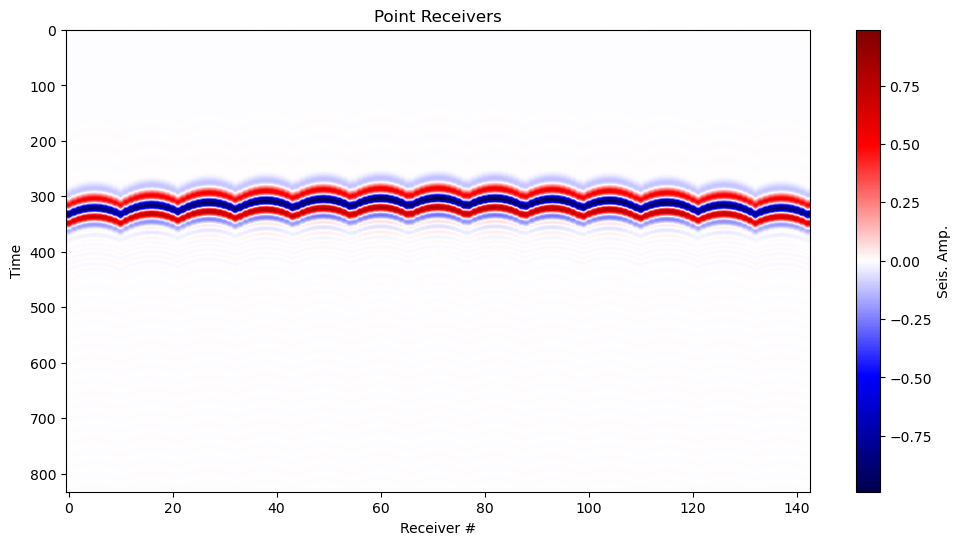

In [8]:
ax = traceimage(vz, climQ=99.99)
ax.set_title('Point Receivers')

In [9]:
# Remove absorbing boundaries
mod = mod_w_bounds[abs_bounds:-abs_bounds,abs_bounds:-abs_bounds,:-abs_bounds] # z has free surface
nx, ny, nz = mod.shape
x, y, z = np.arange(nx)*dx, np.arange(ny)*dy, np.arange(nz)*dz
print(nx,ny,nz)
recs = np.array([recs_xzy[0]-(abs_bounds*dx),recs_xzy[2]-(abs_bounds*dx),recs_xzy[1]])

52 68 90


--------------------------

# SETUP - MODEL, REC GEOM, SOURCES

In [10]:
# Microseismic sources
sx = nx//2
sy = ny//2
sz = 2*nz//3

print(sx,sy,sz)
microseismic = np.zeros((nx, ny, nz))
microseismic[sx, sy, sz] = 1.

26 34 60


---------------

# MAKE DATA

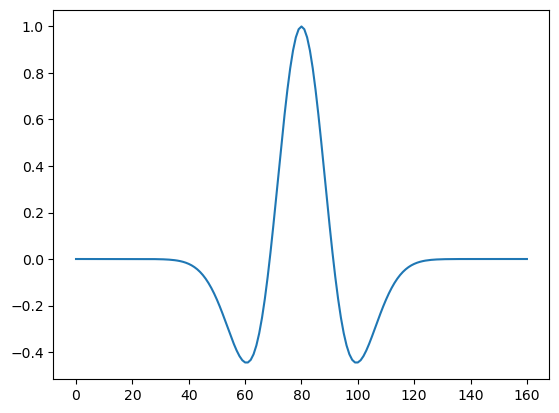

In [11]:
dt = sdt
nt = vz.shape[1]
t = np.arange(nt)*dt
wav, wavt, wavc = ricker(t[:81], f0=20)
plt.plot(wav)

In [12]:
# INITIALISE OPERATOR
Op = Kirchhoff(z=z, 
               x=x, 
               y=y, 
               t=t, 
               srcs=recs[:, :1], 
               recs=recs, 
               vel=1000*np.ones_like(mod), 
               wav=wav, 
               wavcenter=wavc, 
               mode='eikonal', 
               engine='numba')

# check operator with dottest
_ = dottest(Op, verb=True)

Dot test passed, v^H(Opu)=-3893.557526398063 - u^H(Op^Hv)=-3893.55752639811


Text(0.5, 1.0, 'Point Receivers')

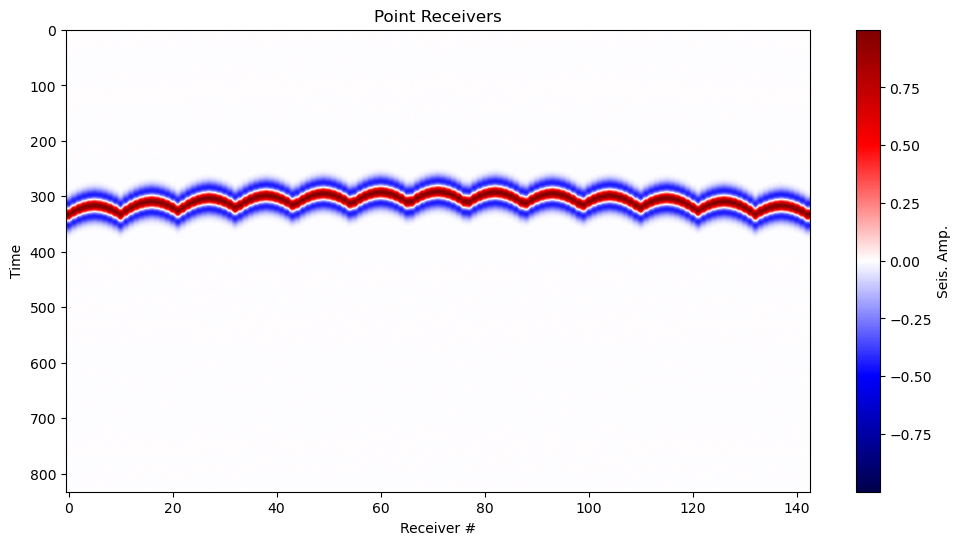

In [13]:
# PERFORM FORWARD (MODEL)
frwddata_1d = Op @ microseismic.flatten().squeeze()
frwddata  = frwddata_1d.reshape(nr,nt)
ax = traceimage(frwddata, climQ=99.99)
ax.set_title('Point Receivers')

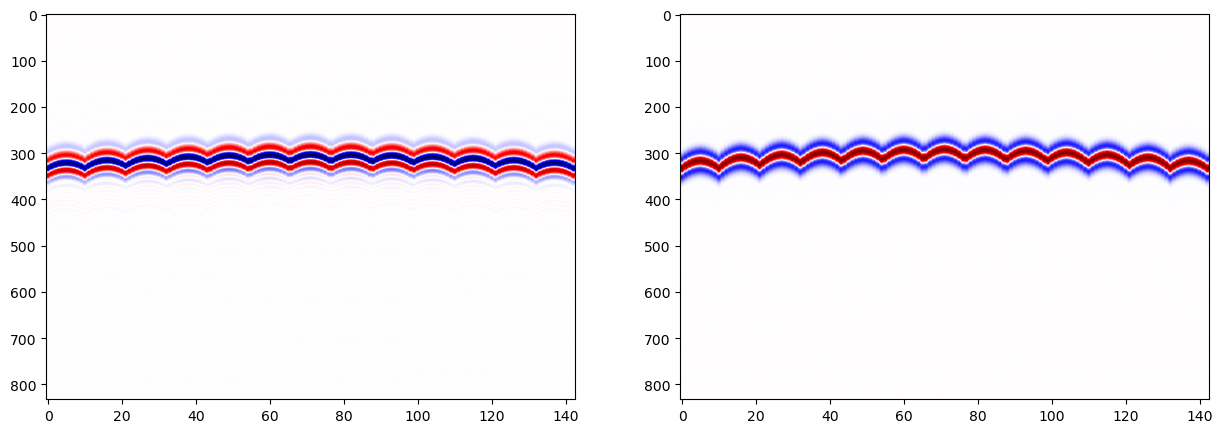

In [14]:
fig, axs = plt.subplots(1,2,figsize=[15,5])
axs[0].imshow(vz.T,aspect='auto', cmap='seismic', vmin=-1,vmax=1)
axs[1].imshow(frwddata.T,aspect='auto', cmap='seismic', vmin=-1,vmax=1)
# for ax in axs:ax.set_ylim([150,50])

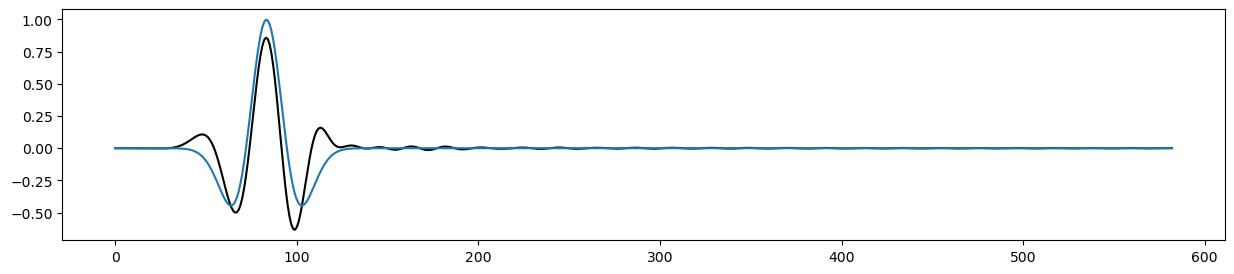

In [15]:
# Double check shift was correct
tshift=0
plt.figure(figsize=[15,3])
plt.plot(-1*vz[10,250+tshift:],'k')
plt.plot(frwddata[10,250:])

-------------------

# MIGRATE 
## Doesn't work in real life as assumes modelling operator can be applied in reverse and return location, i.e., requires data was actually made with the operator (e.g., synthetic)

In [16]:
from pyfrac.locationsolvers.imaging import *
from pyfrac.locationsolvers.crosscorr_imaging import xcorr_imaging

True Hypo-Center: [26, 34, 60]
Migration Hypo-Centers: [131. 170. 300.]


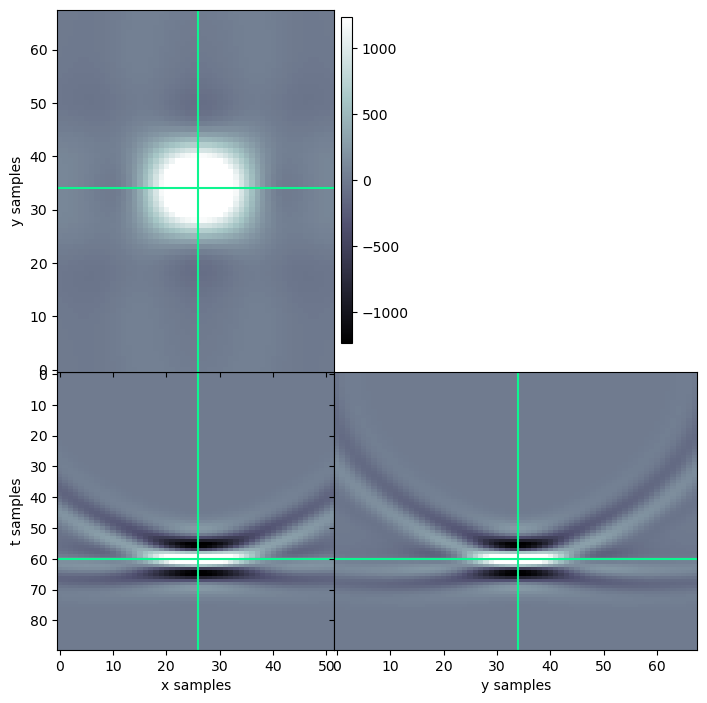

In [17]:
migrated, mig_hc = migration(Op, frwddata, [nx,ny,nz], nforhc=10)  # (Op.H @ frwddata).reshape(nx,ny,nz)
print('True Hypo-Center:', [sx,sy,sz])
print('Migration Hypo-Centers:', mig_hc)

fig,axs = locimage3d(migrated,x0=sx, y0=sy, z0=sz)

True Hypo-Center: [26, 34, 60]
Migration Hypo-Centers: [26.2 34.  61. ]


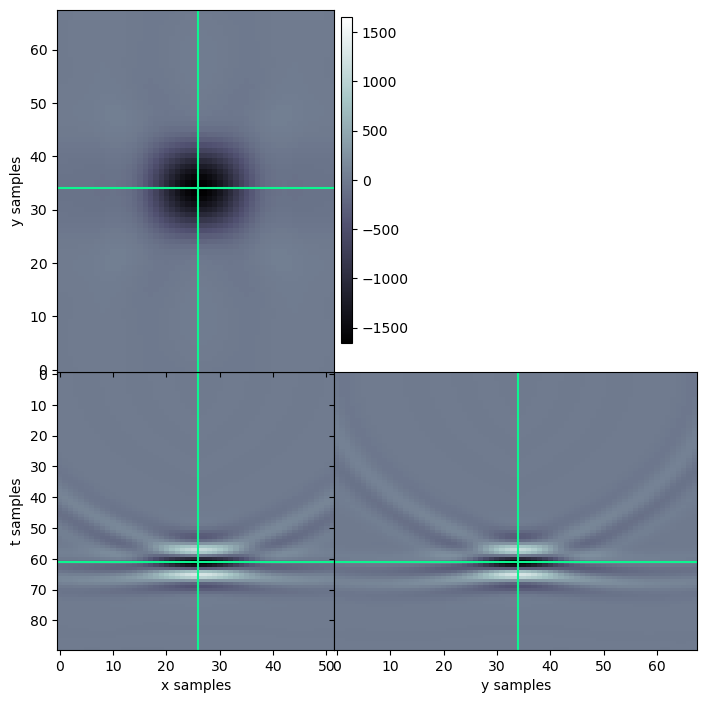

In [18]:
migrated, mig_hc = migration(Op, vz, [nx,ny,nz], nforhc=10) 
print('True Hypo-Center:', [sx,sy,sz])
print('Migration Hypo-Centers:', mig_hc)

fig,axs = locimage3d(migrated,
                     x0=int(np.round(mig_hc[0])), 
                     y0=int(np.round(mig_hc[1])), 
                     z0=int(np.round(mig_hc[2])), 
                     p=100)

--------------------------------

# INVERSION

## LEAST-SQUARES

True Hypo-Center: [26, 34, 60]
LSQR Inversion Hypo-Centers: [26.  34.  63.8]


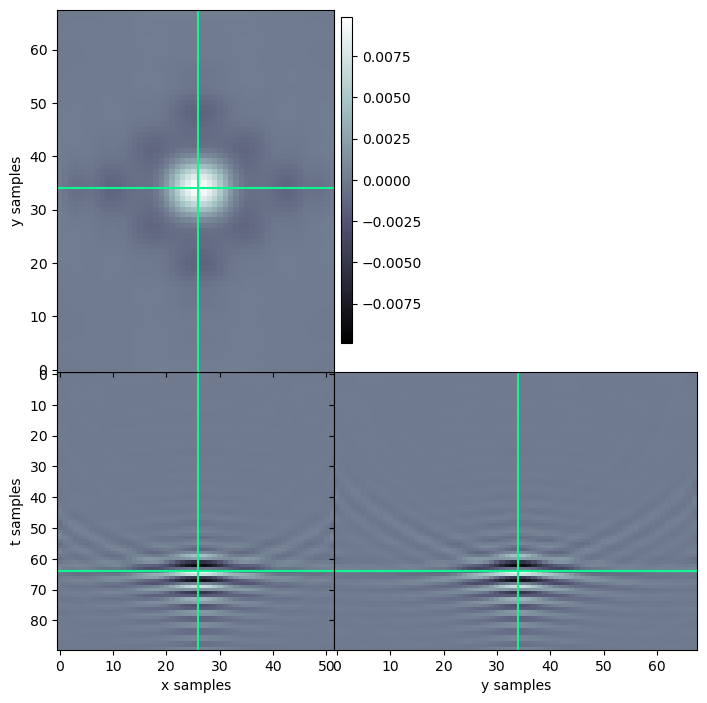

In [19]:
inv, inv_hc = lsqr_migration(Op, vz, [nx,ny,nz], nforhc=10, verbose=False)
print('True Hypo-Center:', [sx,sy,sz])
print('LSQR Inversion Hypo-Centers:', inv_hc)
fig,axs = locimage3d(inv,  
                     x0=int(np.round(inv_hc[0])), 
                     y0=int(np.round(inv_hc[1])), 
                     z0=int(np.round(inv_hc[2])), 
                     p=100)


## FISTA

True Hypo-Center: [26, 34, 60]
FISTA Inversion Hypo-Centers: [25.8 34.  64. ]


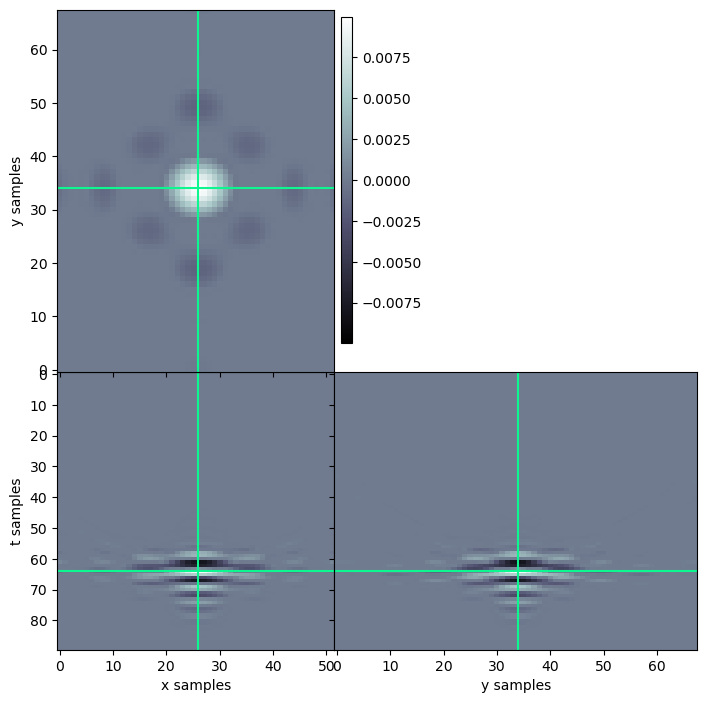

In [21]:
fista, fista_hc = fista_migration(Op, vz, [nx,ny,nz], nforhc=10, verbose=False, fista_eps=1e1)
print('True Hypo-Center:', [sx,sy,sz])
print('FISTA Inversion Hypo-Centers:', fista_hc)
fig,axs = locimage3d(fista, 
                     x0=int(np.round(fista_hc[0])), 
                     y0=int(np.round(fista_hc[1])), 
                     z0=int(np.round(fista_hc[2])), 
                     p=100)


## CROSS-CORRELATION BASED

Iteration 0, Loss: 4.83844
Iteration 10, Loss: 1.84507
Iteration 20, Loss: 1.15768
Iteration 30, Loss: 0.60670
Iteration 40, Loss: 0.45688
Iteration 50, Loss: 0.22261
Iteration 60, Loss: 0.16898
Iteration 70, Loss: 0.03591
Iteration 80, Loss: 0.01239
Iteration 90, Loss: -0.06592
True Hypo-Center: [26, 34, 60]
X-Corr Imaging Hypo-Center: [26.2 34.  61. ]


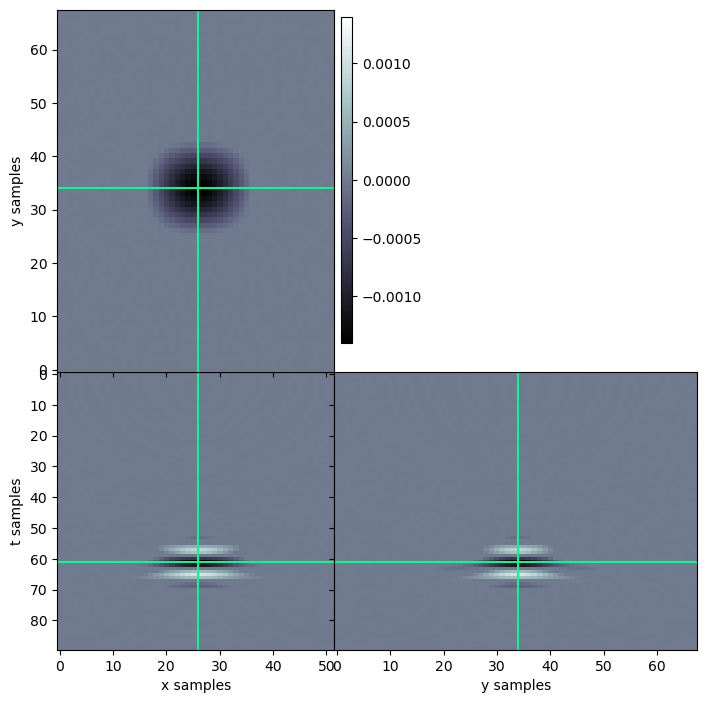

In [22]:
XC_inv, xci_hc, dls_torch, losshist = xcorr_imaging(Op, 
                                                    vz, 
                                                    [nx,ny,nz], 
                                                    niter=100, 
                                                    xceps=8e-1, 
                                                    lr=1e-5, 
                                                    nforhc=10, 
                                                    verbose=True)

print('True Hypo-Center:', [sx,sy,sz])
print('X-Corr Imaging Hypo-Center:', xci_hc)
fig,axs = locimage3d(XC_inv,
                     x0=int(np.round(xci_hc[0])), 
                     y0=int(np.round(xci_hc[1])), 
                     z0=int(np.round(xci_hc[2])), 
                     p=100)